# One More Look at Folding

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result


    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [4]:
rgb_pts=[]
for i in range(map.shape[0]):
    for j in range(map.shape[1]):
        rgb_pts.append([i, j, map[i, j, 0], map[i, j, 1], map[i, j, 2]])
rgb_pts=np.array(rgb_pts).astype('float')

tmp=rgb_pts[:,1]/(960) #-1 #Scale to -1 to 1 for now
rgb_pts[:,1]=(960-rgb_pts[:,0])/(960) #-1
rgb_pts[:,0]=tmp

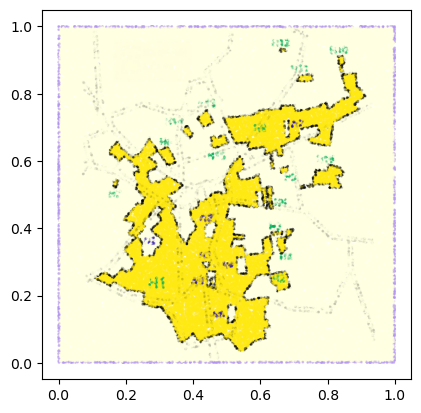

In [5]:
pts_sampled = rgb_pts[np.random.choice(rgb_pts.shape[0], 100000, replace=False)]

plt.scatter(pts_sampled[:, 0], pts_sampled[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

In [6]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
model_path='../models/2_2_1.pth'
model = BaarleNet([2,2])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [8]:
h1=model.model[0](torch.tensor(pts_sampled[:, :2]).float())
h1=h1.detach().numpy()

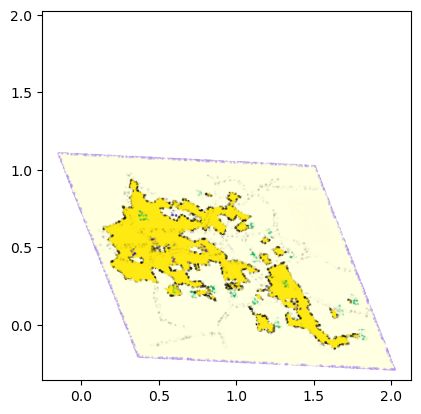

In [9]:
plt.scatter(h1[:, 0], h1[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

In [10]:
h2=model.model[:2](torch.tensor(pts_sampled[:, :2]).float())
h2=h2.detach().numpy()

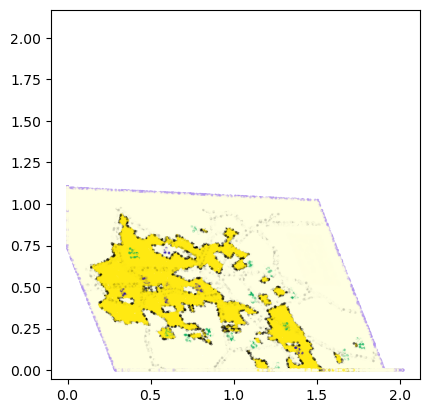

In [11]:
plt.scatter(h2[:, 0], h2[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

In [13]:
h3=model.model[:3](torch.tensor(pts_sampled[:, :2]).float())
h3=h3.detach().numpy()

In [14]:
h3.shape

(100000, 2)

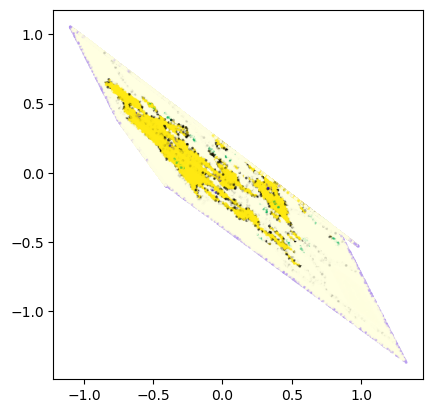

In [15]:
plt.scatter(h3[:, 0], h3[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

In [17]:
h4=model.model[:4](torch.tensor(pts_sampled[:, :2]).float())
h4=h4.detach().numpy()

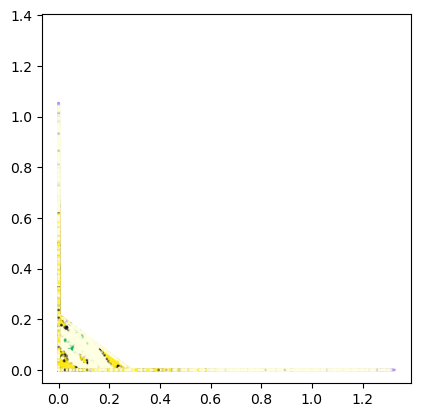

In [18]:
plt.scatter(h4[:, 0], h4[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

The idea of this becomming linearly seperable is interesting...

In [21]:
h5=model.model[:5](torch.tensor(pts_sampled[:, :2]).float())
h5=h5.detach().numpy()

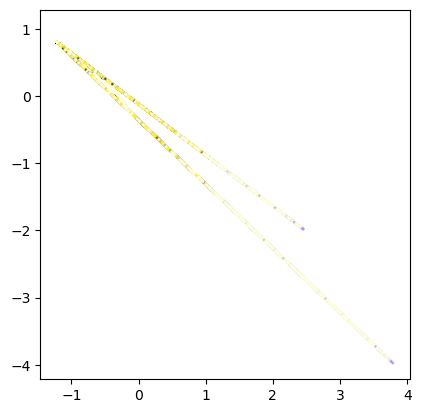

In [22]:
plt.scatter(h5[:, 0], h5[:, 1], c=pts_sampled[:,2:]/255., s=1.0, alpha=0.5)
plt.axis('square');

Hmm hmm, there might be something interesting here with the linear regions - how *are* these pictures connected...

In [20]:
model.model[:4]

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
)